### Searching a circuit that can produce all non-negative $8$-dimensional vectors
a parametrized circuit can produce various final states from the ground state |000> the final states are complex vectors and their component-wise absolute value would be non-negative real vectors of norm $1$

this notebook explores one direction trying to build a circuit that would cover all those real vectors, the whole non-negative sphere (for simplicity, the real absolute values are analyzed rather than the complex final state vectors)

In [1]:
import cirq
import numpy as np
import random 
import pandas as pd
import itertools
from scipy.stats import special_ortho_group
from sklearn.metrics import pairwise_distances  # (X, Y=None, metric='euclidean')
#import math
from functools import reduce
from scipy.spatial import distance_matrix

from state_generation_2 import (get_state_function, 
                                sphere_samples,
                                yrot_sympy_matrix, 
                                plot_gen_image, 
                                approx_target_state)

#from scipy.optimize import minimize
import sympy as sp
from sympy.physics.quantum import TensorProduct

import matplotlib.pyplot as plt

identity_2d = sp.Matrix(np.eye(2)) 

#### define y-rotation matrix, identity matrix and to get the function from circuit paramters to final operator

#### define functions for plotting
1. to plot the image of the function from circuit parameters to final states
2. to generate a sample of the sphere

### Create circuit with three qbits to generate non-negative $8$-dimensional vectors
the produced $2^3 = 8$-dim vector is defined by the probabilities in the final state of the circuit (starting in ground state |000>)  
for the start the circuit consists of one y-rotation on each qbit

In [2]:
n = 3 # number of qbits
# get symbols for the angles defining the y rotations for each qubit
phi_base_rot = sp.symbols(" ".join(['phi_'+str(i) for i in range(n)]))
# list of y rotation operators, one per qubit i, depending on angle phi_i
yrot_per_qubit = [yrot_sympy_matrix(phi_base_rot[i]) for i in range(n)]
# take the tensor product of all the distinct rotation operator
yrot_per_qbit = reduce(TensorProduct, yrot_per_qubit)
# show first column of operator, i.e. the image of the ground state
print("the symbolic image of the ground state, it is also the function from circuit parameters to final states:")
yrot_per_qbit[:,0]

the symbolic image of the ground state, it is also the function from circuit parameters to final states:


Matrix([
[cos(phi_0/2)*cos(phi_1/2)*cos(phi_2/2)],
[sin(phi_2/2)*cos(phi_0/2)*cos(phi_1/2)],
[sin(phi_1/2)*cos(phi_0/2)*cos(phi_2/2)],
[sin(phi_1/2)*sin(phi_2/2)*cos(phi_0/2)],
[sin(phi_0/2)*cos(phi_1/2)*cos(phi_2/2)],
[sin(phi_0/2)*sin(phi_2/2)*cos(phi_1/2)],
[sin(phi_0/2)*sin(phi_1/2)*cos(phi_2/2)],
[sin(phi_0/2)*sin(phi_1/2)*sin(phi_2/2)]])

lambdify the symbolic final state to get the function object

In [3]:
state_generator_0, gen_args_0 = get_state_function(yrot_per_qbit)

arguments of state_generator: {phi_0, phi_2, phi_1}


use this function object to plot a sample of the image, i.e., all non-negative $8$-dim vectors that can be produced by the circuit

the image of the parameter space of the circuit is in red, for comparison a sample of all non-negative unit vectors (i.e. the sphere) is plotted in blue

the plot shows all $2$-dim projections of the $8$-dim space  
for different perspective random_rotation=True can be set which applies a random rotation to all points before projecting, and hence giving a new, random, perspective in each projection

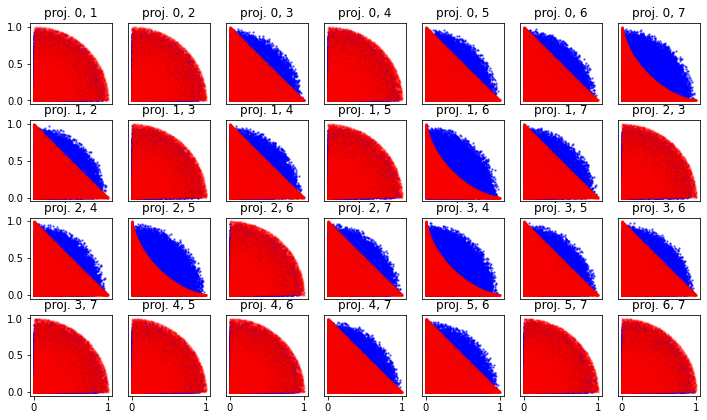

In [5]:
plot_gen_image(state_generator_0, n, gen_args_0, random_rotation=False)

#### 1st extension of the circuit with an additional y-rotation and a permutation with the goal to extend the image

In [6]:
phi_3 = sp.symbols('phi_3')
yrot_add_1 = reduce(TensorProduct, [yrot_sympy_matrix(phi_3)]+[identity_2d]*2)

c = cirq.Circuit()
switch_4567_gates = [
    cirq.CNOT(cirq.GridQubit(0, 0),cirq.GridQubit(1, 0)),
    cirq.CNOT(cirq.GridQubit(0, 0),cirq.GridQubit(2, 0)),
]
c.append(switch_4567_gates)
switch_4567 = sp.Matrix(np.real(c.unitary()).astype(int) )

again, get the function object for the map from parameters to final states and plot as above

In [7]:
add_yrot_permuts_1 = (  yrot_add_1*switch_4567 
                        *yrot_per_qbit
                    )
state_generator_1, gen_args_1 = get_state_function(add_yrot_permuts_1)

arguments of state_generator: {phi_2, phi_3, phi_0, phi_1}


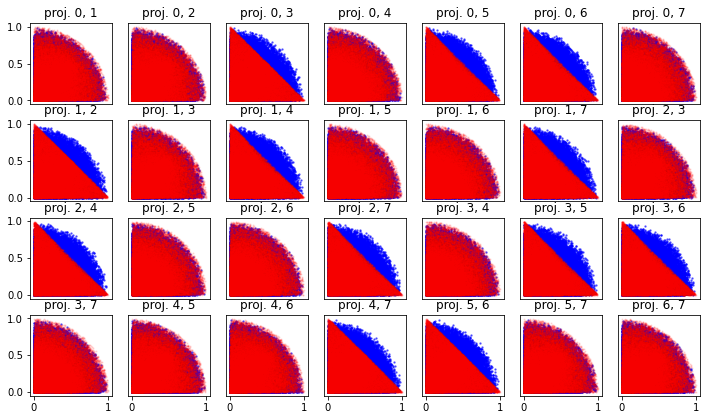

In [11]:
plot_gen_image(state_generator_1, n, gen_args_1, random_rotation=False)

#### 2nd extension of the circuit with an additional y-rotation and a permutation with the goal to extend the image

In [13]:
phi_4 = sp.symbols('phi_4')
yrot_add_2 = reduce(TensorProduct, [yrot_sympy_matrix(phi_4)]+[identity_2d]*2)

# create a toffoli
c = cirq.Circuit()
tofolli_gate = [
    cirq.CCX(cirq.GridQubit(0, 0),cirq.GridQubit(1, 0),cirq.GridQubit(2, 0))
] 
c.append(tofolli_gate)
toffoli = sp.Matrix(np.real(c.unitary()).astype(int) )

arguments of state_generator: {phi_4, phi_2, phi_3, phi_0, phi_1}


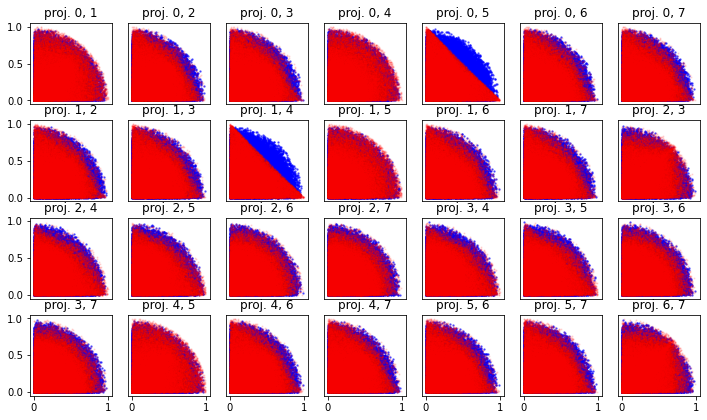

In [14]:
add_yrot_permuts_2 = (  yrot_add_2*toffoli
                        *yrot_add_1*switch_4567 
                        *yrot_per_qbit
                    )

state_generator_2, gen_args_2 = get_state_function(add_yrot_permuts_2)
plot_gen_image(state_generator_2, n, gen_args_2)

#### 3rd extension of the circuit with an additional y-rotation and a permutation with the goal to extend the image
this is the last extension in this example, it seems to fill all the obvious wholes 
on the borders of the sphere the image is rather sparse and it is rather unsure if the circuit can really cover all of the non-negative sphere

further analysis of this extended circuit in the subsequent notebook show that the circuit is not able to cover all

In [15]:
phi_5 = sp.symbols('phi_5')
yrot_add_3 = reduce(TensorProduct, [yrot_sympy_matrix(phi_5)]+[identity_2d]*2)

c = cirq.Circuit()
switch_45_gates = [cirq.CCX.on(cirq.GridQubit(0, 0), cirq.GridQubit(1, 0), cirq.GridQubit(2, 0)),
            cirq.CNOT.on(cirq.GridQubit(0, 0), cirq.GridQubit(2, 0))]
c.append(switch_45_gates)
switch_45 = sp.Matrix(np.real(c.unitary()).astype(int) )

arguments of state_generator: {phi_4, phi_2, phi_3, phi_0, phi_5, phi_1}


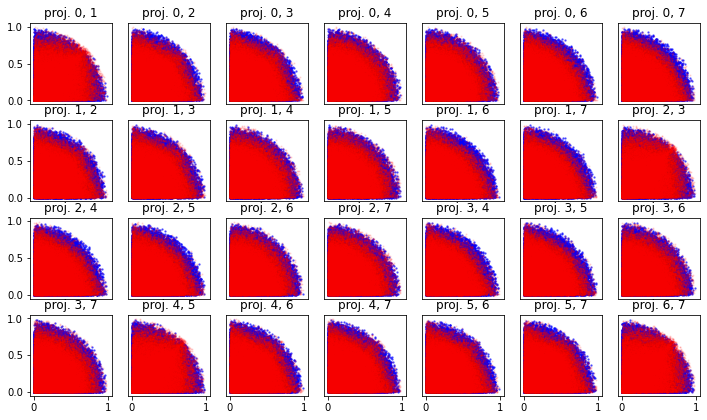

In [16]:
add_yrot_permuts_3 = (  yrot_add_3*switch_45
                        *yrot_add_2*toffoli
                        *yrot_add_1*switch_4567 
                        *yrot_per_qbit
                    )

state_generator_3, gen_args_3 = get_state_function(add_yrot_permuts_3)
plot_gen_image(state_generator_3, n, gen_args_3, random_rotation=False)

### Method to approximation a given non-negative vector of norm 1 using the state_generator_3 circuit


#### Test approximating point that actually lies in the image of state generator
we would expect a very good approximation or even exact fit
the results show instead that approximations objective value is varying extremely and are often very bad

__conclusion:__ the approximation method is not well suited for that problem  



In [30]:
# plot the objective values for a series of approximations on random points from the image of stat generator
obvals_image_approx = []
for k in range(20):
    # create random set of circuit paramters
    rand_args = np.random.uniform(0,2*np.pi,len(gen_args_3))
    target = np.abs(state_generator_3(rand_args)).flatten()
    # .. and approximate it with the circuit
    appox_result = approx_target_state(state_generator_3, gen_args_3, target)
    obvals_image_approx.append(appox_result["objective_value"])


2.910599814804234e-13, 0.031494277773077145, 0.15750971106447537, 1.5459830702646792e-14, 2.8441001681421824e-16, 1.3655294776559912e-13, 3.3651938581239517e-14, 2.017859386365978e-13, 0.09283370553104928, 2.9923200984197354e-14, 0.15866753484114815, 2.2576852524842256e-13, 0.0053303052561033525, 0.0016514941651540477, 0.06528495527488777, 0.08972454614750704, 0.013982784609464831, 2.074932308159344e-13, 8.078341349031843e-14, 2.1863008948761464e-14, 

In [ ]:
# plot the objective values for a series of approximations on random points from non-negative sphere
obvals_sphere_approx = []
for k in range(20):
    # create a random target vector 
    target = sphere_samples(n_dim=2**n, n_samples=1, subset="non-negative").flatten()
    # .. and approximate it with the circuit
    appox_result = approx_target_state(state_generator_3, gen_args_3, target)
    obvals_sphere_approx.append(appox_result["objective_value"])